## 1. Read in the data

In [1]:
import json

TRPATH = "../data/data_practicephase_cleardev/MD-Agreement_dataset/MD-Agreement_train.json"
DEVPATH = "../data/data_practicephase_cleardev/MD-Agreement_dataset/MD-Agreement_dev.json"


with open(TRPATH, 'rb') as file:
    tr_data = json.load(file)
with open(DEVPATH, 'rb') as file:
    dev_data = json.load(file)

len(tr_data)

6592

In [2]:
# Check for languages
lang = set()
for val in tr_data.values():
    lang.add(val['lang'])
lang

{'en'}

## 2. Data exploring

### 2.1 Measuring topic polarity

We use the formula `some_form` to quantify the polarizing nature of topics

In [3]:
import numpy as np


ele20_pol = []
blm_pol = []
cov19_pol = []

for val in tr_data.values():
    polarizability = 1 - np.absolute(val['soft_label']['0'] - val['soft_label']['1'])
    if val['other_info']['domain'] == 'Covid-19':
        cov19_pol.append(polarizability)
    elif val['other_info']['domain'] == 'Elections2020':
        ele20_pol.append(polarizability)
    elif val['other_info']['domain'] == 'BLM':
        blm_pol.append(polarizability)
    else:
        raise ValueError("Unknown domain")

dev_ele20_pol = []
dev_blm_pol = []
dev_cov19_pol = []

for val in dev_data.values():
    polarizability = 1 - np.absolute(val['soft_label']['0'] - val['soft_label']['1'])
    if val['other_info']['domain'] == 'Covid-19':
        dev_cov19_pol.append(polarizability)
    elif val['other_info']['domain'] == 'Elections2020':
        dev_ele20_pol.append(polarizability)
    elif val['other_info']['domain'] == 'BLM':
        dev_blm_pol.append(polarizability)
    else:
        raise ValueError("Unknown domain")

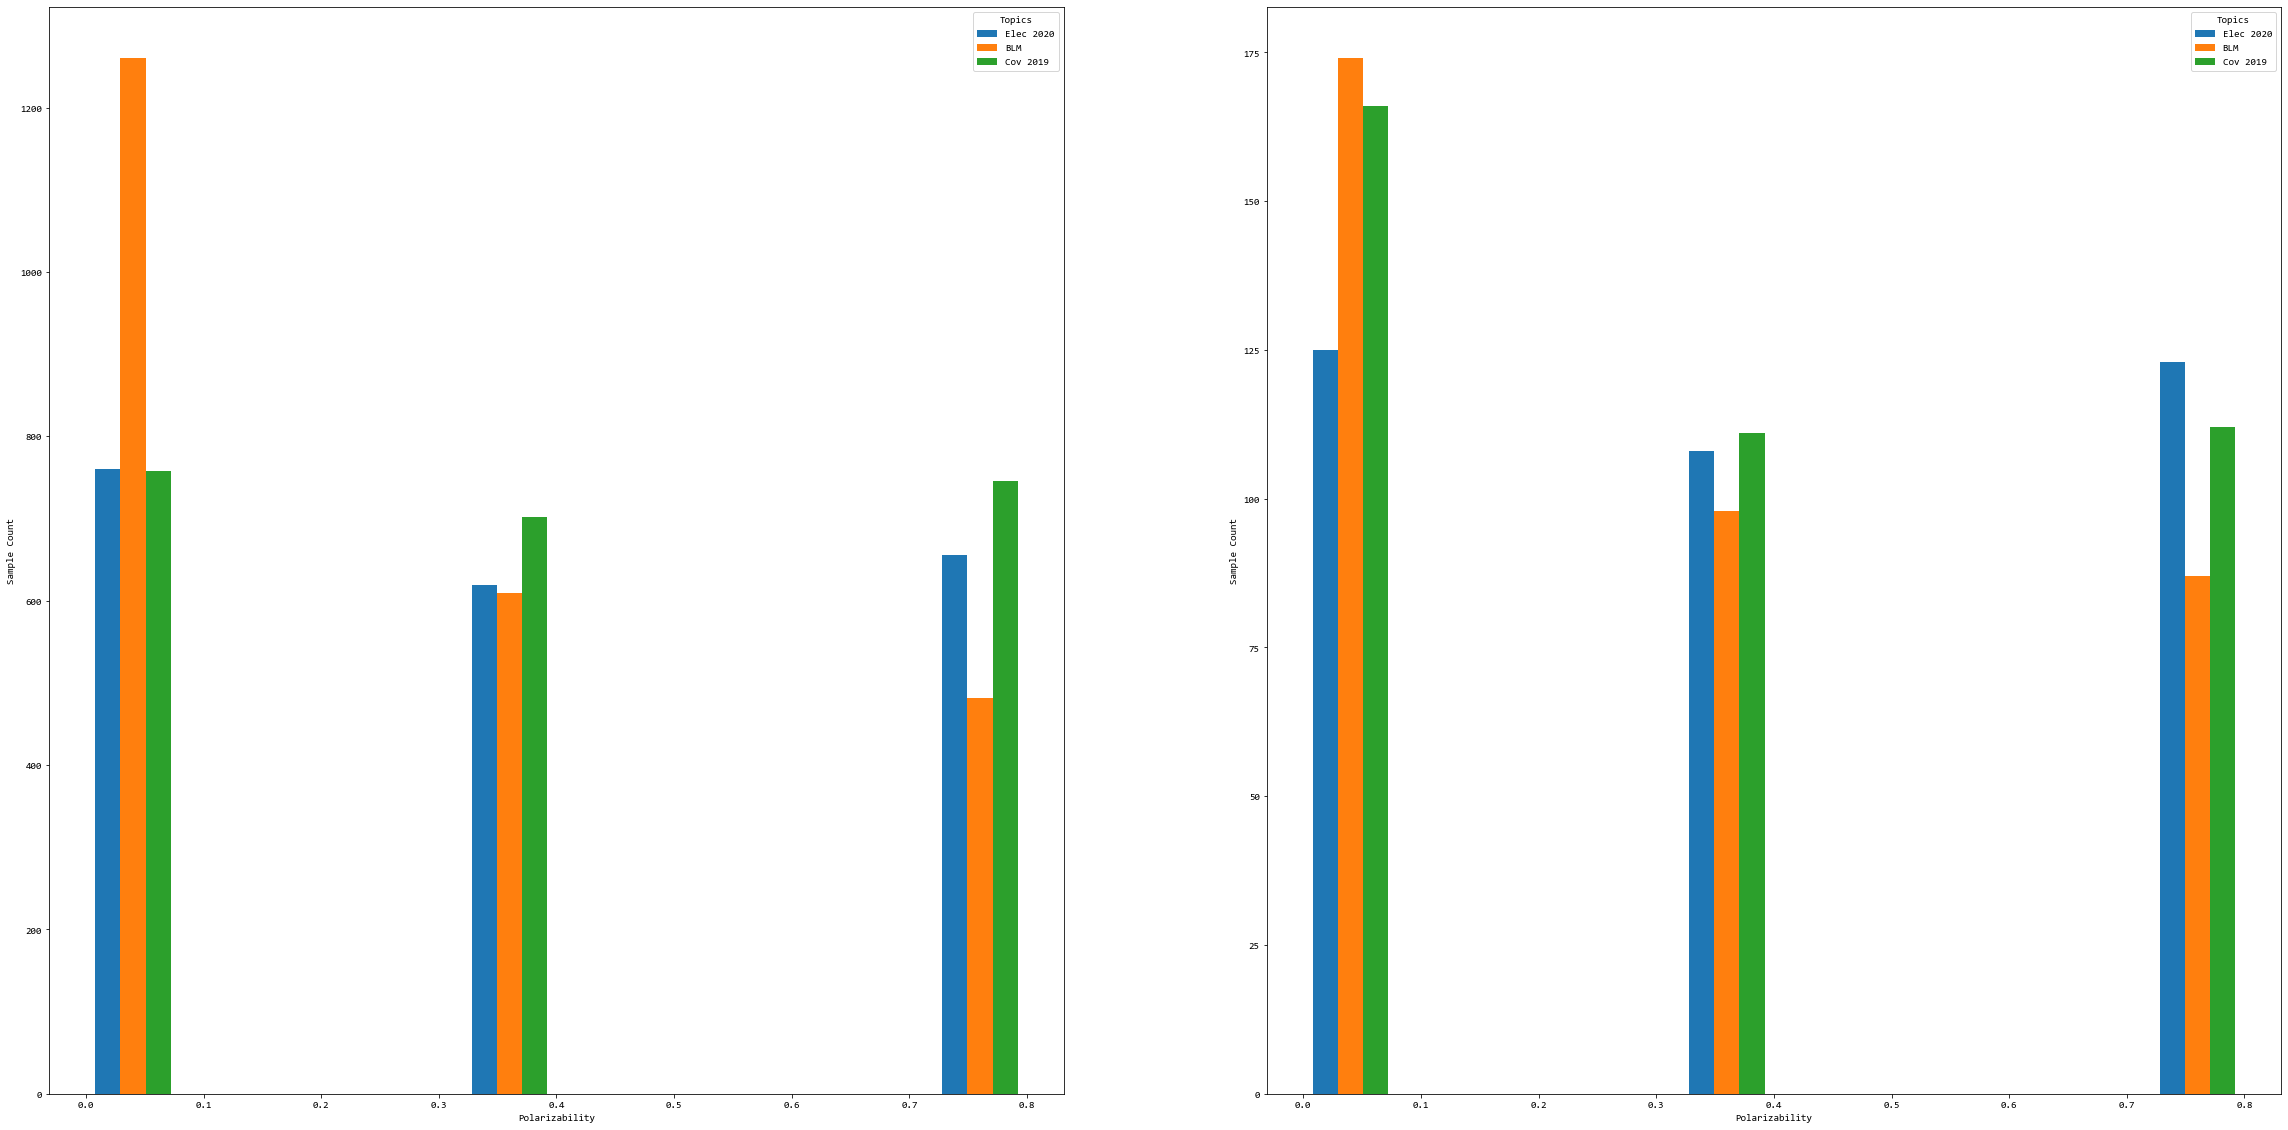

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Consolas"
plt.rcParams['font.size']=24

# Plot the histograms
fig, ax = plt.subplots(1, 2, figsize=[40, 20])
ax[0].hist((ele20_pol, blm_pol, cov19_pol), label=('Elec 2020', 'BLM', 'Cov 2019'))
ax[0].set_xlabel('Polarizability')
ax[0].set_ylabel('Sample Count')
ax[0].legend(title="Topics")

ax[1].hist((dev_ele20_pol, dev_blm_pol, dev_cov19_pol), label=('Elec 2020', 'BLM', 'Cov 2019'))
ax[1].set_xlabel('Polarizability')
ax[1].set_ylabel('Sample Count')
ax[1].legend(title="Topics")

plt.show()

In [37]:
import numpy as np

counts, bin_edges = np.histogram(dev_cov19_pol, bins=3)

In [38]:
counts

array([166, 111, 112], dtype=int64)

In [40]:
112/counts.sum()

0.2879177377892031

## 3. Evaluation

In [ ]:
from mda_modelling import AgreementModel
from pytorch_lightning import Trainer, seed_everything


seed_everything(42, workers=True)

trainer = Trainer(
    deterministic=True,
    accelerator='gpu',
)

CKPT = "../models/md-agreement/all-MiniLM-L12-v2/ft-aug-epoch=4-val_soft_loss=0.12.ckpt"
model = AgreementModel.load_from_checkpoint(CKPT)
print("Loaded checkpoint")

In [ ]:
from datautils import MdaBatcher, MdaDataModule

batcher = MdaBatcher("sentence-transformers/all-MiniLM-L12-v2", has_targets=True)
dm = MdaDataModule(DEVPATH, ["offensiveness detection"], batcher)
dm.setup('test')


preds = trainer.test(model=model, dataloaders=dm)

## 4. Sample Preds

In [ ]:
from datautils import MdaBatcher, MdaDataModule


PRPATH = "../data/data_evaluation/MD-Agreement_test.json"

batcher = MdaBatcher("sentence-transformers/all-MiniLM-L12-v2", has_targets=False)
dm = MdaDataModule(PRPATH, ["offensiveness detection"], batcher)
dm.setup('predict')


preds = trainer.predict(model=model, dataloaders=dm)

In [ ]:
import torch
hard_labels = [i[1].cpu() for i in preds]
soft_labels = [i[2].cpu() for i in preds]

In [ ]:
hard_labels = torch.concat(hard_labels)
soft_labels = torch.concat(soft_labels)
results = torch.hstack((hard_labels, soft_labels))

# Round the values
results = torch.round(results, decimals=2)

In [ ]:
import pandas as pd
df = pd.DataFrame(results.numpy())

df[0] = df[0] .astype(int)

df.to_csv('MD-Agreement_results.tsv', sep='\t', header=False, index=False)